# Predict Tank5 phase set point from 400 MeV BPM data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn.mixture
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

%matplotlib widget
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["savefig.format"] = 'pdf'
plt.rc("axes",prop_cycle= plt.cycler("color", plt.cm.tab20.colors))

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler

print(tf.__version__)

2.8.1


## DNN regression models

The base model contains the following layers:

* The normalization layer.
* N hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear output layer.

We also test a model without input normalization layer.

In [3]:
def build_and_compile_model(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(32, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_len(norm, init_lr, numlabel):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(32, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(int(numlabel))
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_square(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model
def build_and_compile_model_nobatch(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'), #200
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model


def build_and_compile_model_nonorm(inputs,init_lr):
  model = keras.Sequential([
      keras.Input(shape=(inputs,)),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

## Define learning schedules and training

In [4]:
# Define learning schedules 

initial_lr = 0.001

def lr_time_based_decay(epoch, lr):
    epochs = 400
    decay = initial_lr / epochs
    return lr * 1 / (1 + decay * epoch)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 200.0
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_lr * math.exp(-k*epoch)



In [5]:
def train_model(model,features,labels,eps,lrs=None):
    if lrs is None:
        history = model.fit(
            features, 
            labels,
            validation_split=0.2,
            batch_size=64, #30
            verbose=0,
            epochs=int(eps)
        )
    else:
        history = model.fit(
            features, 
            labels, 
            validation_split=0.2,
            batch_size=64,
            verbose=0,
            epochs=int(eps), 
            callbacks=[LearningRateScheduler(lrs, verbose=0)],
        )
    return history

## Define plotting functions

In [6]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_multi_loss(histories):
    fig, ax = plt.subplots(len(histories),1,figsize=(9,9))
    for i in range(len(histories)):
        ax[i].plot(histories[i].history['loss'], label='loss')
        ax[i].plot(histories[i].history['val_loss'], label='val_loss')
        ax[i].set_ylim([0, 0.5])
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()
        ax[i].grid(True)
        
    fig.tight_layout()


In [7]:
def plot_2dhist(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    fig.tight_layout()
    devs = ['V5QSET','RFQ','Buncher']
    
    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        h = ax[i].hist2d(labels.iloc[:,i], predictions[:,i], bins=40, cmin=1, cmap='seismic')
        #ax.set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        ax[i].set(title='%s'%key)
        ax[i].tick_params(axis='both',labelsize=14)
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        ax[i].plot(lims, lims, color='k')
        fig.colorbar(h[3], ax=ax[i])

    fig.supylabel('Predicted $\Delta$ phase (deg)', fontsize=18)
    fig.suptitle('True $\Delta$ phase (deg)', y=0.05, fontsize=18)   
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.14)
    plt.subplots_adjust(right=0.96)  

In [8]:
def plot_2dscatter_many(predictions,labels):

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5))
    if labels[0].shape[1] ==1:
        ax = [ax]

    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]

        for j in range(len(labels)):
            ax[i].scatter(labels[j].iloc[:,i], predictions[j][:,i], label='Data %d'%j)
            #ax[i].fill_between(labels[j].iloc[:,i],[np.min(predictions[j][k,i]) for k in ],np.max(predictions[j][:,i]),alpha=0.5)
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min([np.min(pred[:,i]) for pred in predictions]),np.min([np.min(lab.iloc[:,i]) for lab in labels])),
                max(np.max([np.max(pred[:,i]) for pred in predictions]),np.max([np.max(lab.iloc[:,i]) for lab in labels]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        #print(lims)
        ax[i].plot(lims, lims, color='b')
        ax[i].legend(ncol=2,fontsize=14, loc='upper left')
    fig.tight_layout()

In [9]:
def plot_2dscatter(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        ax[i].scatter(labels.iloc[:,i], predictions[:,i], color='r')
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        print(lims)
        ax[i].plot(lims, lims, color='b')    
    fig.tight_layout()

In [10]:
def plot_1derror(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    devs = ['phase set point']
    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5),sharey=False)
    fig.tight_layout()
    
    nbins=60
    if labels.shape[1]==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        error =(predictions[:,i] - labels.iloc[:,i])
        error = [e for e in error if e <3*np.std(error)]

        ax[i].hist(error, bins=nbins, color='r', edgecolor='k', alpha=0.65, label='Data')
        #ax[i].set(title='%s'%key ,xlabel='Prediction Error (deg)', ylabel='Count')
        ax[i].set(title='%s'%key)
        #ax[i].xaxis.label.set_size(13)
        #ax[i].yaxis.label.set_size(13)
        
        ers = np.array(error)[:,None]
        gmm = sklearn.mixture.GaussianMixture()  
        r = gmm.fit(ers)
        mean = r.means_[0, 0]
        sigma = np.sqrt(r.covariances_[0,0])
        textstr = '\n'.join((
                    r'$\mu=%.2f$' % (mean,),
                    r'$\sigma=%.2f$' % (sigma,)))
        print(textstr)                                                                                                                  
        xlin = np.linspace(np.min(error),np.max(error),1000).reshape(-1,1)                                                                                                                             
        pdf = np.exp(gmm.score_samples(xlin))
        binsize = (np.max(error) - np.min(error))/nbins
        ax[i].plot(xlin,pdf*(len(error)*binsize),color='k', label='Gauss fit')
        ax[i].text(0.05, 0.65, textstr, transform=ax[i].transAxes, color='k', fontsize=14,                                                                                
                           verticalalignment='top', bbox=props)
        ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


In [11]:
def plot_1derror_many(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5),sharey=False)
    fig.tight_layout()
    if labels[0].shape[1]==1:
        ax = [ax]
    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]
        nbins=40
        for j in range(len(labels)):
            error =(predictions[j][:,i] - labels[j].iloc[:,i])
            error = [e for e in error if e <1*np.std(error)]
            if i not in[2,3]:
                ax[i].hist(error, bins=nbins, alpha=0.45, label='Data')
            else:
                ax[i].hist(error, bins=100, alpha=0.45, label='Data')
        ax[i].set(title='%s'%key)
        #ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


## Define data loading functions

In [12]:
def fetch_data(file,datacols,cuts,setdevs):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]
    
    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)
    
    # augment jumps in phase data
    #subset['B:BQ3F'] = subset['B:BQF3'].apply(lambda x : x if x > 0 else x +360)
    subset.dropna()
    
    return subset

In [13]:
def fetch_reference(dataset,devs,setvals,stepsize):
    
    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]

    #reference = dataset.loc[(np.abs(dataset[devs[0]]-setvals[0])<0.5)].mean()
    reference = dataset.loc[eval('&'.join(conds)).ravel()].mean()
    return reference

In [14]:
def fetch_slice(dataset,devs,setvals,stepsize):
    
    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]

    sliced = dataset.loc[eval('&'.join(conds)).ravel()]
    return sliced

In [15]:
def fetch_features_labels(dataset,targetdevs):
    features = dataset.copy()
    labelstr = list(dataset.filter(regex='|'.join(targetdevs)))
    labels = features.loc[:,labelstr]
    features.drop(columns=labelstr, inplace=True)
    
    return features,labels

In [16]:
dist_data = [26.5,27.0, 43.5, 44.0,60.8, 77.0,78.3,79.6,
            80.8, 82.5, 84.4,
            88.2, 90.1, 92.1,
            96.3, 98.4, 100.6, 102.8,
            105.0, 109.6, 111.9,
            114.7, 116.7, 119.1, 121.6,
            124.0, 126.5, 129.6, 131.6,
                 134.2, 136.8, 139.4, 141.6]
#D42 : 107.3

# 1-phase model: T5 reading

In [17]:
path = r'/Users/rshara01/Desktop/LINAC_STUDY/BEAM STUDY '
files=[r'15FEB2023/devicescan.csv','4JAN2023/devicescan_t5_1.csv']
cavs = ['L:V5QSET']

#dataset = fetch_data(file,['V5S','BF','BPH','BPV','BPM'],'',['V5QSET_R'])
#dataset.drop(list(dataset.filter(regex=r'3IF|20|IN|OT|D7|D6|D5|D4|D3|D1|D0|B:|SS|SQT')),axis=1, inplace=True)

dfs1d = [fetch_data('%s%s'%(path,f),cavs+['BF','BPM','V5S'],'',['%s_R'%c[2:] for c in cavs]) for f in files]
dfs1d = [df.drop(list(df.filter(regex=r'3IF|20|B:|SS|SQT|D42')),axis=1) for df in dfs1d]
dfs1d[1] = dfs1d[1].iloc[:-1,:]

meds1d = [[np.median(df[c]) for c in cavs] for df in dfs1d]

steps1d = [[0.09],[0.09]]
refs1d = [fetch_reference(df,cavs,med,step) for df,med,step in zip(dfs1d,meds1d,steps1d)]

dfs1d = [df-ref for df,ref in zip(dfs1d,refs1d)]

### Split the data into train and test

We split the dataset into a training set and a test set.
The test set is used in the final evaluation of the model.

In [18]:
train_data1 = dfs1d[0].iloc[:,1:].sample(frac=0.8, random_state=11)
test_data1 = dfs1d[0].iloc[:,1:].drop(train_data1.index)

### Split features from labels

Separate the target values, the "labels", from the features. These labels are the values that we train the model to predict: in this case Tank 5 phase.

In [19]:
train_ft1, train_lbl1 = fetch_features_labels(train_data1,['L:V5SQ']) #V5QSET
test_ft1, test_lbl1 = fetch_features_labels(test_data1,['L:V5SQ'])

## Normalization
To improve training we normalize all inputs to the same range. The normalization layer calculates the mean and variance, and stores them in the layer. 
When the layer is called it returns the input data, with each feature independently normalized.

In [21]:
train_ft1.describe().transpose()[['mean','std']].transpose()
normal1 = preprocessing.Normalization(axis=-1)
normal1.adapt(np.array(train_ft1))

2023-04-03 16:26:01.773874: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Train the model

In [22]:
%%time

model_1ph = build_and_compile_model(normal1, initial_lr)
model_1ph.summary()
history_time_decay = train_model(model_1ph,train_ft1,train_lbl1,1000,lr_time_based_decay)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 32)               65        
 ion)                                                            
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                        

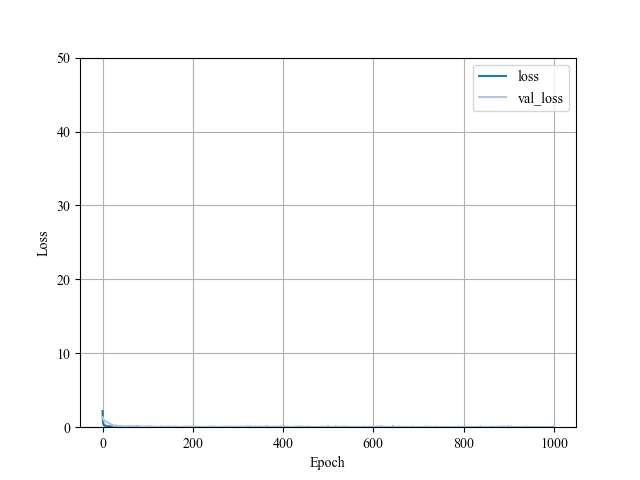

In [23]:
%matplotlib widget
plot_loss(history_time_decay)

If you're happy with the model save it for later use:

In [24]:
#dnn_model13.save('dnn_model13_l7padj_22122022')
# in the future, to load a trained model:
# loaded_model = tf.keras.models.load_model('dnn_model13_l7padj_22122022')
# my_features,my_labels = fetch_features_labels(vdf)
# my_predictions = loaded_model.predict(my_features)

## Performance
Test the model on the test set:

In [25]:
testpred1 = model_1ph.predict(test_ft1)

$\mu=0.00$
$\sigma=0.08$


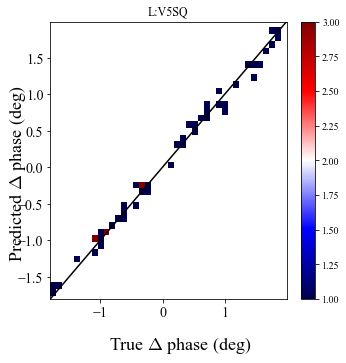

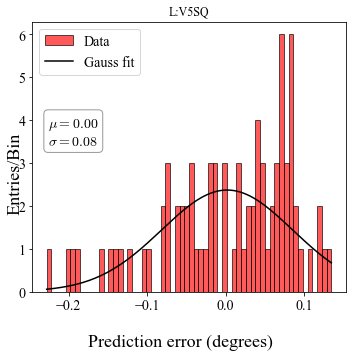

In [26]:
%matplotlib inline
plot_2dhist(testpred1,test_lbl1)
plot_1derror(testpred1,test_lbl1)

## Validation on independent sample

$\mu=0.00$
$\sigma=0.13$


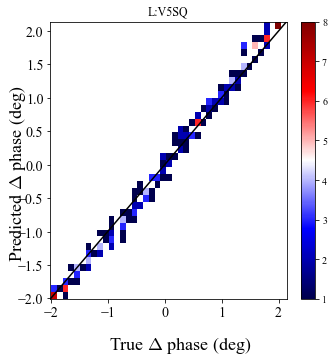

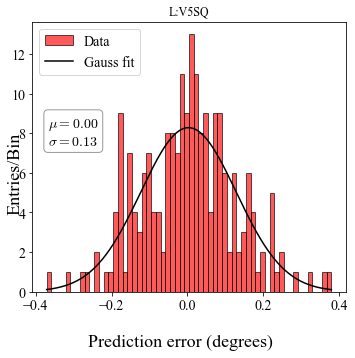

In [27]:
val_ft1,val_lbl1 = fetch_features_labels(dfs1d[1].iloc[:,1:],['L:V5SQ'])

valpred1 = model_1ph.predict(val_ft1)

%matplotlib inline
plot_2dhist(valpred1,val_lbl1)
plot_1derror(valpred1,val_lbl1)

## Tuning test

In [28]:
path = '/Users/rshara01/Desktop/LINAC_STUDY/BEAM STUDY 23FEB2023/'
prefix = 'correlatedPulseData'

phases = ['_t5-1deg','_t5-05deg','','_t5+05deg','_t5+1deg','_extv-05kV','_extv-025kV','_extv+025kV','_extv+05kV']

files = [r'%s%s%s.csv'%(path,prefix,ph) for ph in phases]

subs = [pd.read_csv(f,skiprows=42) for f in files]

#subs = [df.loc[:,list(df.filter(regex = 'BPH|BPV|BF|V5S|BPM5IF'))].dropna() for df in dfs]
#subs = [sub.drop(list(sub.filter(regex=r'3IF|20|IN|OT|D7|D6|D5|D4|D3|D1|D0|B:|SS|SQT')),axis=1) for sub in subs]
subs = [df.loc[:,list(df.filter(regex = 'BF|BPM|BF|V5S'))].dropna() for df in subs]
subs = [sub.drop(list(sub.filter(regex=r'3IF|20|B:|SS|SQT|D42')),axis=1) for sub in subs]
subs = [subs[i] - subs[2] for i in range(len(files))] # subtract ref

In [30]:
dphase = [sub['L:V5SQ'].mean() for sub in subs]
var = list(train_ft1.columns)
#var = ['L:BPM5IF','L:D21BF','L:D22BF','L:D23BF','L:D21BPH','L:D22BPH','L:D23BPH','L:D21BPV','L:D22BPV','L:D23BPV']
dpos = [[-sub[v].mean() for sub in subs] for v in var]

preds=list(next(zip(*model_1ph.predict(pd.DataFrame(dict(zip(var,dpos)),index=range(len(dphase)))))))

print(preds)

[0.68493223, 0.3677033, -0.016177662, -0.6313102, -0.8014609, 0.63148344, 0.36969554, -0.1309008, -0.21409664]


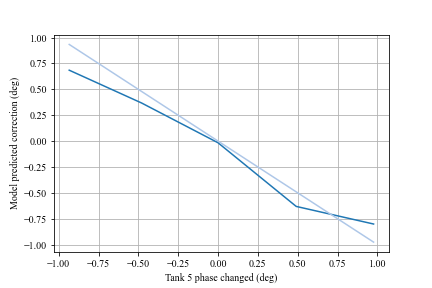

In [31]:
%matplotlib widget

plt.plot(dphase[:5],preds[:5])
plt.plot(dphase[:5],np.multiply(dphase[:5],-1))
plt.xlabel("Tank 5 phase changed (deg)")
plt.ylabel("Model predicted correction (deg)")
plt.grid()

## BPM phase oscillation

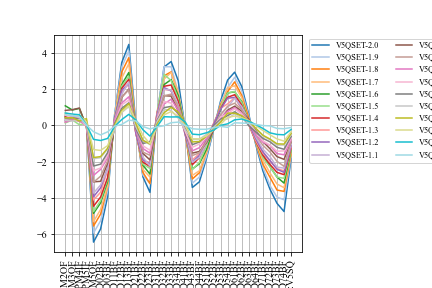

In [32]:
dfmed= dfs1d[0].groupby(np.arange(len(dfs1d[0]))//10).median()

%matplotlib widget

plt.xticks(rotation=90)
[plt.plot(dfmed.iloc[k,1:], label='V5QSET%.1f'%dfmed.iloc[k,0]) for k in range(20)]
plt.grid()
plt.legend(ncol=2,bbox_to_anchor=(1.01, 1), loc="upper left",fontsize = 'small')
#plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.subplots_adjust(right=0.7)

# 3-phase and 2-phase models: (RFQ,) T2, T5 setting

In [17]:
path = r'/Users/rshara01/Desktop/LINAC_STUDY/BEAM STUDY '
files =['14DEC2022/devicescan.csv','09OCT2022/devicescan_rfq_t2_t5.csv']
cavs = ['L:RFQPAH','L:V2QSET','L:V5QSET']

dfs = [fetch_data('%s%s'%(path,f),cavs+['BF','BPM','V2S','V5S'],'',['%s_R'%c[2:] for c in cavs]) for f in files]

dfs = [df.drop(list(df.filter(regex=r'20|B:|SS|SQT|D42')),axis=1) for df in dfs]

# quality cuts 
dfs[0].iloc[0,:] = dfs[0].iloc[1,:]
dfs[0].iloc[99,:] = dfs[0].iloc[100,:]
dfs[0].iloc[297,:] = dfs[0].iloc[298,:]
dfs[0].iloc[1386,:] = dfs[0].iloc[1387,:]
dfs[0].iloc[1477,:] = dfs[0].iloc[1478,:]
dfs[0].iloc[1683,:] = dfs[0].iloc[1684,:]
dfs[0].iloc[1738,:] = dfs[0].iloc[1739,:]
dfs[0].iloc[2574,:] = dfs[0].iloc[2575,:]
dfs[0].iloc[2673,:] = dfs[0].iloc[2674,:]
dfs[0].iloc[2970,:] = dfs[0].iloc[2971,:]
dfs[0].iloc[3960,:] = dfs[0].iloc[3961,:]
dfs[0].iloc[3982,:] = dfs[0].iloc[3983,:]
dfs[0].iloc[4950,:] = dfs[0].iloc[4951,:]
dfs[0].iloc[5346,:] = dfs[0].iloc[5347,:]
dfs[0].iloc[5445,:] = dfs[0].iloc[5446,:]
dfs[0].iloc[5841,:] = dfs[0].iloc[5842,:]
dfs[0].iloc[5940,:] = dfs[0].iloc[5941,:]
dfs[0].iloc[6435,:] = dfs[0].iloc[6436,:]
dfs[0].iloc[6534,:] = dfs[0].iloc[6535,:]
dfs[0].iloc[7128,:] = dfs[0].iloc[7129,:]
dfs[0].iloc[7326,:] = dfs[0].iloc[7327,:]
dfs[0].iloc[7623,:] = dfs[0].iloc[7624,:]
dfs[0].iloc[7821,:] = dfs[0].iloc[7822,:]
dfs[0].iloc[8118,:] = dfs[0].iloc[8119,:]
dfs[0].iloc[8910,:] = dfs[0].iloc[8911,:]
dfs[0].iloc[9207,:] = dfs[0].iloc[9208,:]
dfs[0].iloc[9306,:] = dfs[0].iloc[9307,:]
dfs[0].iloc[9603,:] = dfs[0].iloc[9604,:]
dfs[0].iloc[9801,:] = dfs[0].iloc[9802,:]
dfs[0].iloc[10098,:] = dfs[0].iloc[10099,:]
dfs[0].iloc[10494,:] = dfs[0].iloc[10495,:]
dfs[0].iloc[10890,:] = dfs[0].iloc[10891,:]
dfs[0].iloc[10989,:] = dfs[0].iloc[10990,:]
dfs[0].iloc[11088,:] = dfs[0].iloc[11089,:]
dfs[0].iloc[11286,:] = dfs[0].iloc[11287,:]
dfs[0].iloc[11884,:] = dfs[0].iloc[11885,:]
dfs[0] = dfs[0].iloc[:-1,:]

dfs[1].iloc[0,:] = dfs[1].iloc[1,:]
dfs[1].iloc[5940] = dfs[1].iloc[5941]
dfs[1] = dfs[1].iloc[:-1,:]

meds = [[np.median(df[c]) for c in cavs] for df in dfs]
#print(meds)

stepsize = [[3.,0.5,0.3],[3.9,0.35,0.4]]
refs = [fetch_reference(df,cavs,med,step) for df,med,step in zip(dfs,meds,stepsize)]
#refs.append(fetch_reference(dfs[1],cavs,meds[0],[1.9,0.4,0.2]))
#print(refs)

ddfs = [df-ref for df,ref in zip(dfs,refs)]
#ddfs.append(dfs[1] - refs[2])


## Plot BPM phase oscillation

In [34]:
ssdf = []
for i in range(3):
    cav = [c for c in cavs if c!=cavs[i]]
    ssdf.append([fetch_slice(df,cav,[0.,0.],[0.3,0.3]) for df in ddfs])

ssdf =[[df.sort_index().reset_index(drop=True) for df in s] for s in ssdf]
ssdf = [[df.dropna() for df in s] for s in ssdf]

ssdf[0][1].drop([99],inplace=True)

print([[df.shape for df in s] for s in ssdf])
#ssdfmed= [[df.groupby(np.arange(len(df))//9).median() for df in s] for s in ssdf]
ssdfmed= [[df.groupby(np.arange(len(df))//9).mean() for df in s] for s in ssdf]
print([[df.shape for df in s] for s in ssdfmed])

[[(99, 38), (99, 38)], [(99, 38), (99, 38)], [(99, 38), (99, 38)]]
[[(11, 38), (11, 38)], [(11, 38), (11, 38)], [(11, 38), (11, 38)]]


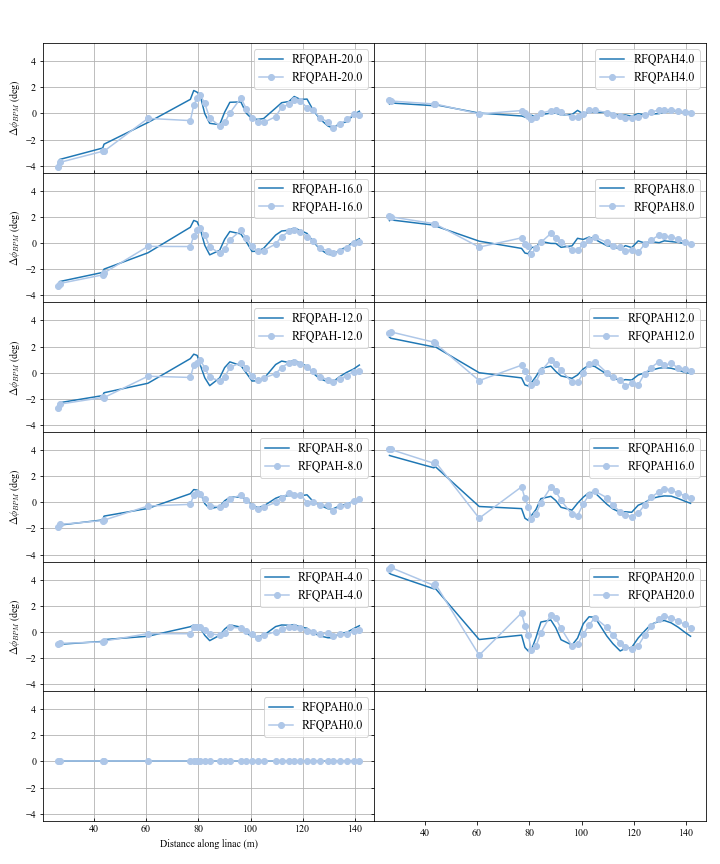

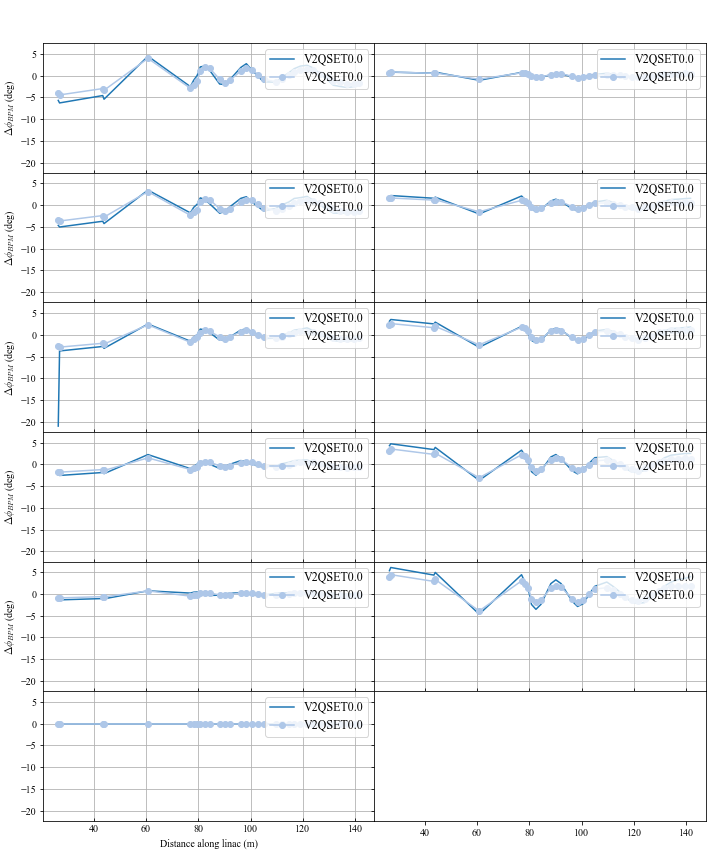

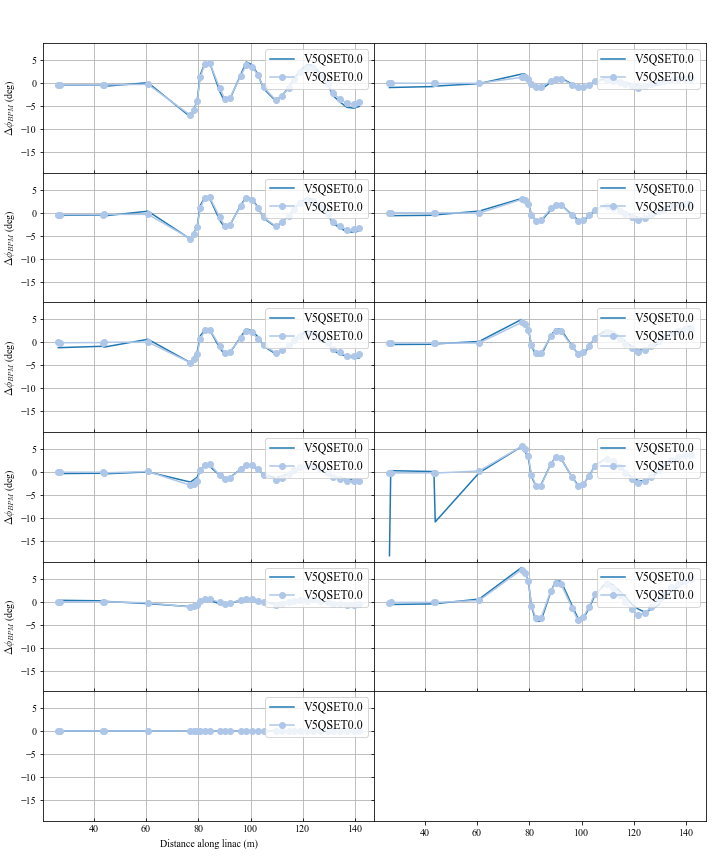

In [35]:
%matplotlib widget

nplots = ssdfmed[0][0].shape[0]
nrows = int(nplots/2) if nplots%2==0 else int(nplots/2)+1

devs = ['RFQPAH','V2QSET','V5QSET']

for i in range(3):
    fig, axs = plt.subplots(nrows,2, figsize=(10,12), sharex=True, sharey=True)
    for k in range(nplots):
        axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][0].iloc[k,3:-2], label='%s%.1f'%(devs[i],ssdfmed[i][0].iloc[k,0]), marker='',linestyle='-')
        axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][1].iloc[k,3:-2], label='%s%.1f'%(devs[i],ssdfmed[i][1].iloc[k,0]), marker='o',linestyle='-')

        axs[int(k%(nplots/2))][int(k*2/(nplots))].legend(loc='upper right', fancybox=True, fontsize='large')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].xaxis.set_tick_params(direction='in', which='major')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].grid(True)
        #axs[int(k%(nplots/2))][int(k*2/(nplots))].set_ylim(-4.,5)
        if int(k%(nplots/2))==nrows-1:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(xlabel='Distance along linac (m)')
        elif int(k/(nplots/2))%2==0:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(ylabel='$\Delta \phi_{BPM}$ (deg)')
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(bottom=0.05)
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(left=0.06)
    plt.subplots_adjust(right=0.98)

Text(0, 0.5, '$\\Delta \\phi$ (deg)')

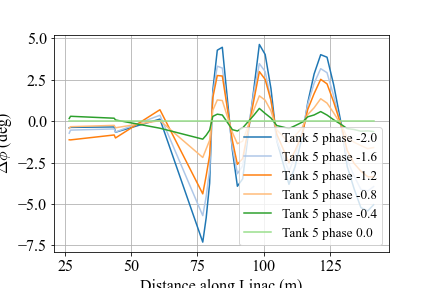

In [136]:
%matplotlib widget
plt.rcParams.update({'font.size': 16})
#[plt.plot(dist_data,ssdfmed[0][0].iloc[k,3:-2], label='RFQ phase %.1f'%(ssdfmed[0][0].iloc[k,0]), marker='',linestyle='-') for k in range(6) ]

[plt.plot(dist_data,ssdfmed[2][0].iloc[k,3:-2], label='Tank 5 phase %.1f'%(ssdfmed[2][0].iloc[k,2]), marker='',linestyle='-') for k in range(6)]
plt.grid()
plt.legend(loc="lower right",fontsize = 'small')
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")

## 3-phase model

In [36]:
train_data2 = ddfs[0].iloc[:,:-2].sample(frac=0.8, random_state=11)
test_data2 = ddfs[0].iloc[:,:-2].drop(train_data2.index)

train_ft2, train_lbl2 = fetch_features_labels(train_data2,['L:RFQPAH','L:V2QSET','L:V5QSET'])
test_ft2, test_lbl2 = fetch_features_labels(test_data2,['L:RFQPAH','L:V2QSET','L:V5QSET'])

normal2 = preprocessing.Normalization(axis=-1)
normal2.adapt(np.array(train_ft2))

In [37]:
%%time

model_3ph = build_and_compile_model_len(normal2, initial_lr, train_lbl2.shape[1])
model_3ph.summary()
history_3ph = train_model(model_3ph,train_ft2,train_lbl2,600,lr_time_based_decay)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 33)               67        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                1088      
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

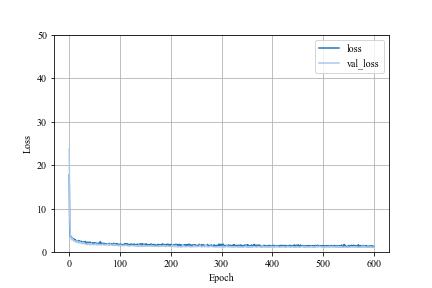

In [38]:
%matplotlib widget
plot_loss(history_3ph)

75/75 [==============================] - 0s 289us/step - loss: 1.2725
$\mu=-0.04$
$\sigma=1.82$
$\mu=0.03$
$\sigma=0.26$
$\mu=0.01$
$\sigma=0.16$


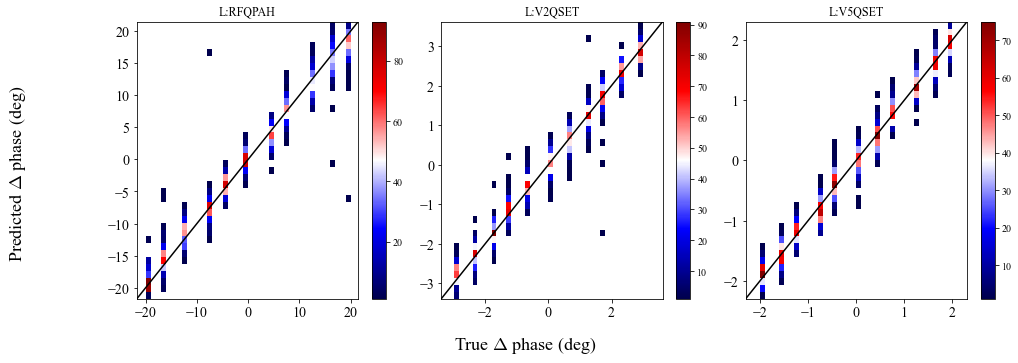

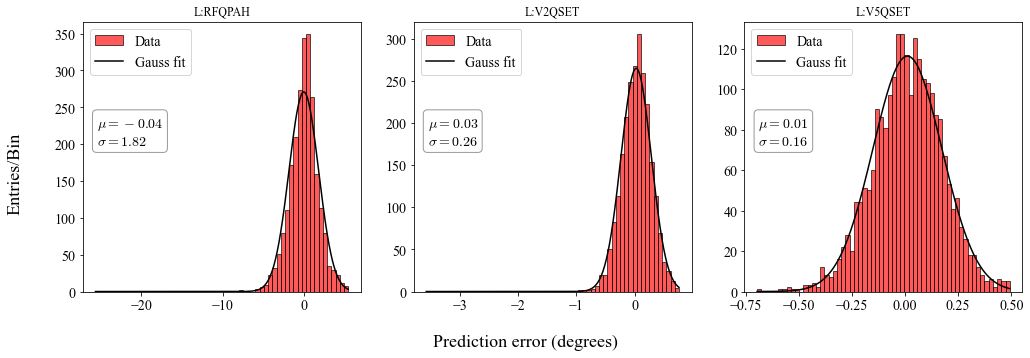

In [40]:
model_3ph.evaluate(test_ft2, test_lbl2, verbose=1)
testpred2 = model_3ph.predict(test_ft2)

%matplotlib inline
plot_2dhist(testpred2,test_lbl2)
plot_1derror(testpred2,test_lbl2)

$\mu=1.15$
$\sigma=7.54$
$\mu=0.21$
$\sigma=0.50$
$\mu=-0.08$
$\sigma=0.25$


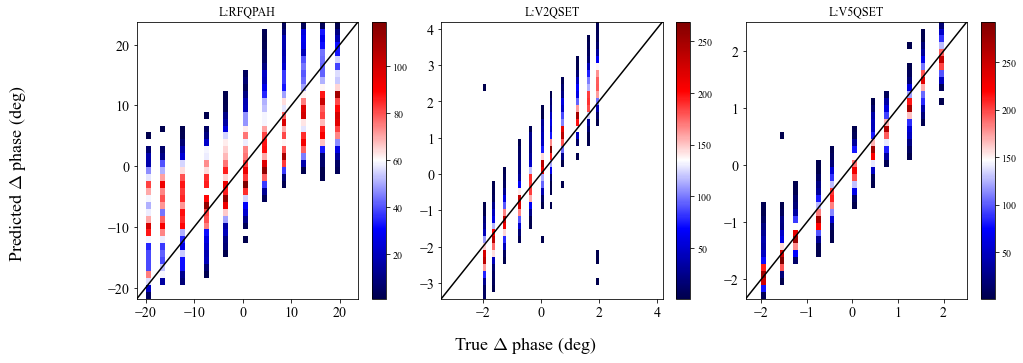

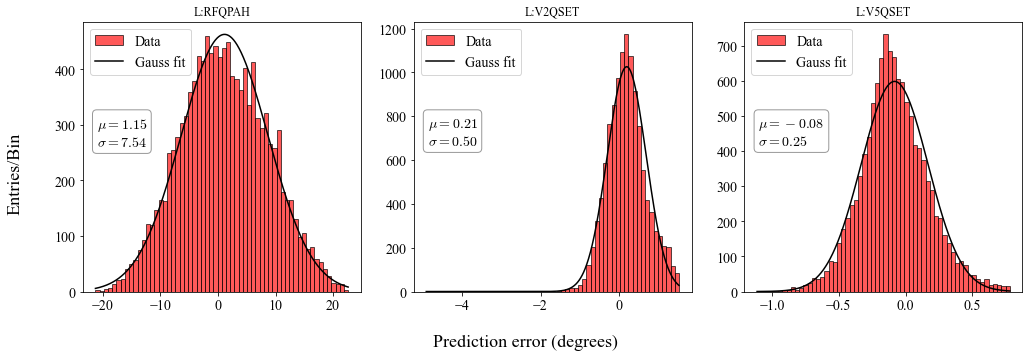

In [41]:
val_ft2,val_lbl2 = fetch_features_labels(ddfs[1].iloc[:,:-2],['L:RFQPAH','L:V2QSET','L:V5QSET'])
valpred2 = model_3ph.predict(val_ft2)

%matplotlib inline
plot_2dhist(valpred2,val_lbl2)
plot_1derror(valpred2,val_lbl2)

## 2-phase model: RFQ phase is fixed

In [18]:
rfqdf = []
for i in range(11):
    rfqdf.append(fetch_slice(ddfs[0],['L:RFQPAH'],[-20+i*4],[1.]))

rfqdf =[df.sort_index().reset_index(drop=True) for df in rfqdf]
rfqdf = [df.dropna() for df in rfqdf]

#rfqdfmed= [[df.groupby(np.arange(len(df))//9).median() for df in s] for s in ssdf]
rfqdfmed= [df.iloc[:,:-2].groupby(np.arange(len(df))//9).mean() for df in rfqdf]

In [19]:
rfqdf[5].iloc[:,1:-2].head()

,L:V2QSET,L:V5QSET,L:BPM2OF,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D02BF,L:D03BF,...,L:D53BF,L:D54BF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,L:D71BF,L:D72BF,L:D73BF,L:D74BF
0,-3.0,-2.0,-6.538696,-6.934814,-5.056152,-5.796509,5.467529,-9.675903,-6.640625,-3.486328,...,3.968506,6.272583,6.147461,3.942871,0.073853,-3.485718,-5.780640,-7.707520,-7.965088,-7.182617
1,-3.0,-2.0,-6.038818,-6.533813,-4.776001,-5.593262,5.830078,-10.032959,-6.986694,-3.837891,...,3.864136,6.146240,6.218872,4.063721,0.013428,-3.557129,-5.731201,-8.125000,-8.063965,-7.303467
2,-3.0,-2.0,-6.774902,-7.176514,-5.220947,-6.021729,5.659790,-9.989014,-6.783447,-3.519287,...,4.094849,6.503296,6.290283,3.992310,0.013428,-3.584595,-5.956421,-8.201904,-8.190308,-7.429810
3,-3.0,-2.0,-6.450806,-6.901855,-5.100098,-5.977783,5.593872,-9.967041,-6.816406,-3.728027,...,4.133301,5.904541,6.301270,4.058228,0.057373,-3.710938,-5.917969,-8.125000,-8.228760,-7.303467
4,-3.0,-2.0,-6.780396,-7.022705,-5.396729,-5.972290,5.385132,-9.758301,-6.816406,-3.728027,...,4.347534,5.904541,6.301270,4.058228,0.057373,-3.485718,-5.917969,-8.125000,-8.228760,-6.891479


In [22]:
train_data3 = rfqdf[5].iloc[:,1:-2].sample(frac=0.8, random_state=11)
test_data3 = rfqdf[5].iloc[:,1:-2].drop(train_data3.index)

train_ft3, train_lbl3 = fetch_features_labels(train_data3,['L:V2QSET','L:V5QSET'])
test_ft3, test_lbl3 = fetch_features_labels(test_data3,['L:V2QSET','L:V5QSET'])

normal3 = preprocessing.Normalization(axis=-1)
normal3.adapt(np.array(train_ft3))

In [23]:
%%time

model_2ph = build_and_compile_model_len(normal3, initial_lr, train_lbl3.shape[1])
model_2ph.summary()
history_2ph = train_model(model_2ph,train_ft3,train_lbl3,600,lr_time_based_decay)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 33)               67        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                1088      
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

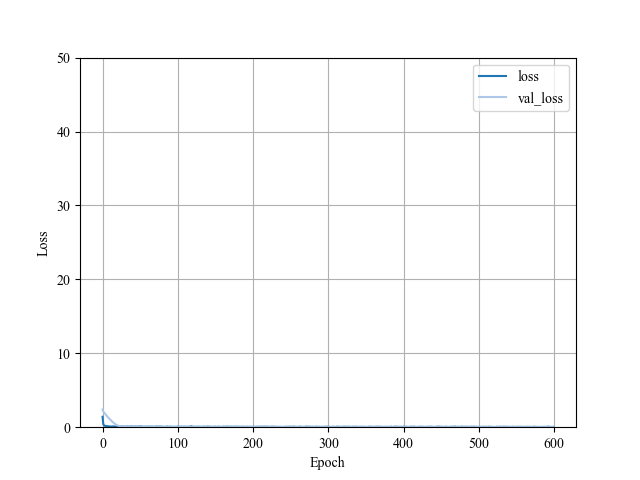

In [24]:
%matplotlib widget
plot_loss(history_2ph)

In [25]:
model_2ph.evaluate(test_ft3, test_lbl3, verbose=1)
testpred3 = model_2ph.predict(test_ft3)

7/7 [==============================] - 0s 2ms/step - loss: 0.0136


$\mu=-0.01$
$\sigma=0.13$
$\mu=-0.00$
$\sigma=0.09$


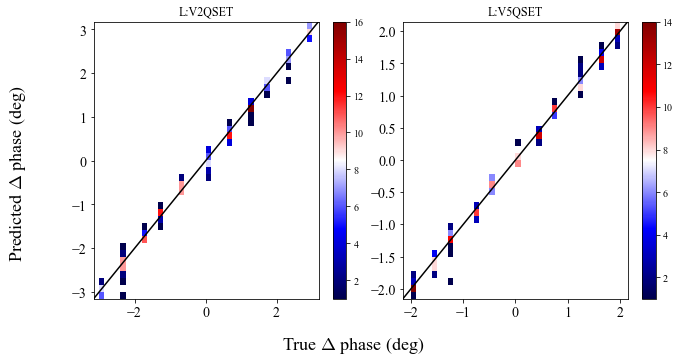

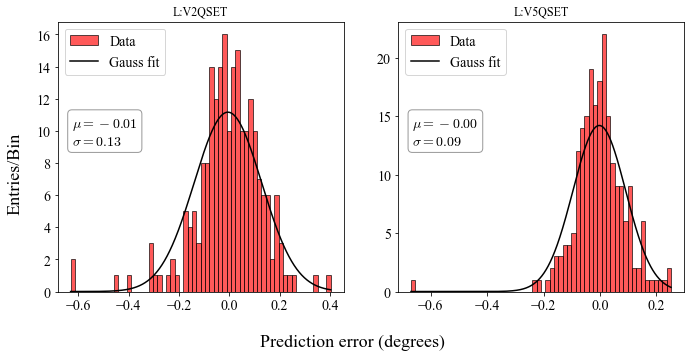

In [26]:
%matplotlib inline
plot_2dhist(testpred3,test_lbl3)
plot_1derror(testpred3,test_lbl3)

In [27]:
tt = [list(fetch_features_labels(df.iloc[:,1:],['L:V2QSET','L:V5QSET'])) for df in rfqdfmed]
preds = [model_2ph.predict(t[0]) for t in tt ]

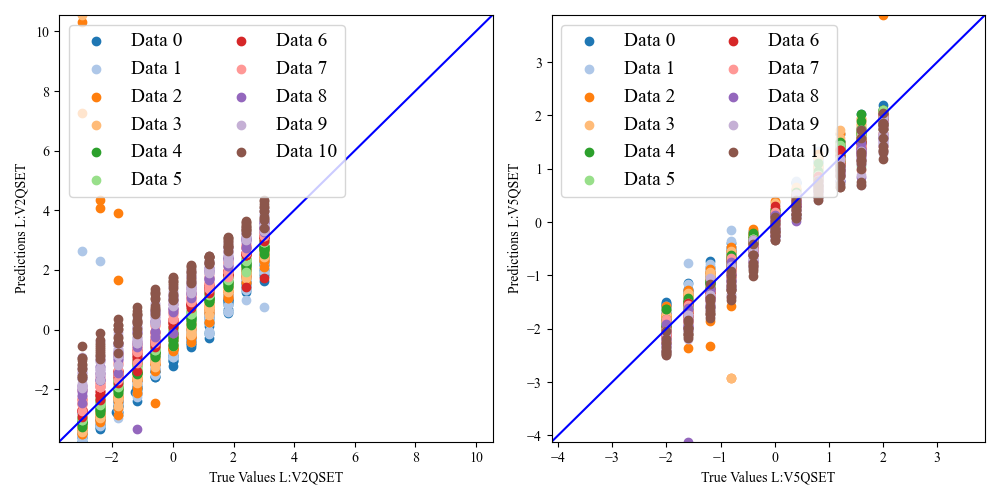

In [28]:
%matplotlib widget
plot_2dscatter_many(preds,[t[1] for t in tt])
#plot_2dhist(preds[5],tt[5][1])

In [29]:
def plot_1derror_many(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5),sharey=False)
    fig.tight_layout()
    if labels[0].shape[1]==1:
        ax = [ax]
    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]
        nbins=40
        for j in range(len(labels)):
            error =(predictions[j][:,i] - labels[j].iloc[:,i])
            error = [e for e in error if e <1*np.std(error)]
            if j not in[2,3]:
                ax[i].hist(error, bins=nbins, alpha=0.45, label='Data %d'%j)
            else:
                ax[i].hist(error, bins=100, alpha=0.45, label='Data %d'%j)
        ax[i].set(title='%s'%key)
        ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96) 

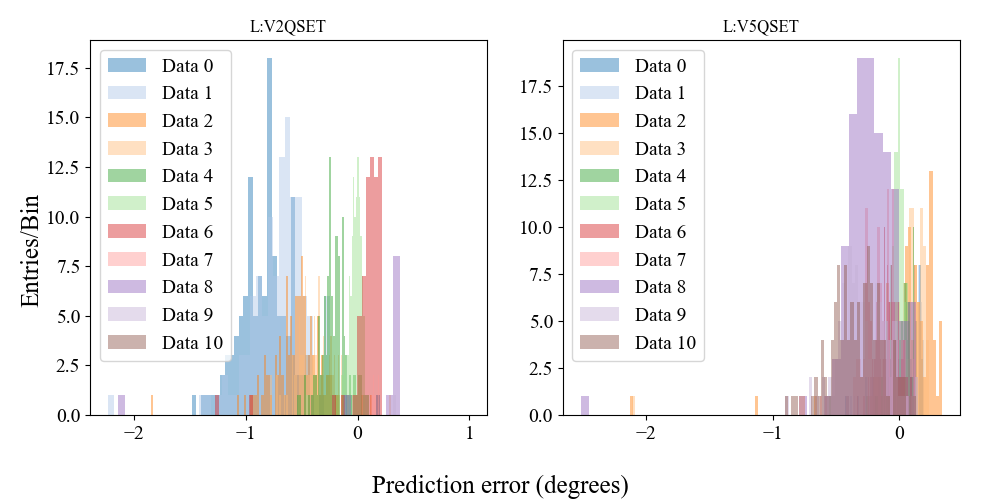

In [30]:
%matplotlib widget
#plot_1derror(preds[5],tt[5][1])
plot_1derror_many(preds,[t[1] for t in tt])

In [65]:
osc1 = [fetch_slice(df,['L:V2QSET','L:V5QSET'],[0,0],[0.1,0.2]) for df in rfqdfmed]
osc1

[df.to_csv('osc_varyRFQ_fixT2T5_%d.csv'%i) for i,df in enumerate(osc1)]
rfqdfmed[5].to_csv('osc_fixRFQ_varyT2T5.csv')

predicted = [model_2ph.predict(osc.iloc[:,3:]) for osc in osc1]
#print([pr for pr in predicted])
osc2 = [fetch_slice(rfqdfmed[5],['L:V2QSET','L:V5QSET'],pr[0],[0.3,0.19]) for pr in predicted ]
[print(osc.iloc[:,:3], pr[0]) for (osc,pr) in zip(osc2,predicted)]

    L:RFQPAH  L:V2QSET  L:V5QSET
58       0.0 -1.200001       0.0 [-1.047 -0.025]
    L:RFQPAH  L:V2QSET  L:V5QSET
59       0.0      -0.6       0.0 [-0.898 -0.068]
Empty DataFrame
Columns: [L:RFQPAH, L:V2QSET, L:V5QSET]
Index: [] [-0.64  -0.192]
    L:RFQPAH  L:V2QSET  L:V5QSET
48       0.0      -0.6 -0.400002 [-0.564 -0.23 ]
    L:RFQPAH  L:V2QSET  L:V5QSET
59       0.0      -0.6       0.0 [-0.543 -0.175]
    L:RFQPAH  L:V2QSET  L:V5QSET
60       0.0       0.0       0.0 [-0.066  0.02 ]
    L:RFQPAH  L:V2QSET  L:V5QSET
61       0.0       0.6       0.0 [ 0.345 -0.043]
    L:RFQPAH  L:V2QSET  L:V5QSET
50       0.0       0.6 -0.400002 [ 0.516 -0.233]
    L:RFQPAH  L:V2QSET  L:V5QSET
50       0.0       0.6 -0.400002 [ 0.686 -0.229]
    L:RFQPAH  L:V2QSET  L:V5QSET
51       0.0  1.200001 -0.400002 [ 0.999 -0.328]
    L:RFQPAH  L:V2QSET  L:V5QSET
51       0.0  1.200001 -0.400002 [ 1.121 -0.336]


[None, None, None, None, None, None, None, None, None, None, None]

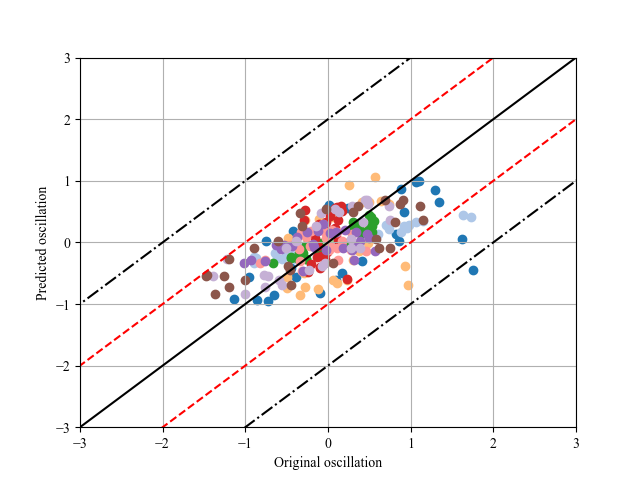

In [89]:
%matplotlib widget
#plt.scatter(osc1[5].iloc[:,3:],osc2[5].iloc[:,3:])
[plt.scatter(o1.mean()[9:],o2.mean()[9:], label='Data %d'%i) for i,(o1,o2) in enumerate(zip(osc1,osc2))]
plt.plot([-11,11],[-11,11],color='k', linestyle = '-')
plt.plot([-11,11],[-9,13],color='k', linestyle = '-.')
plt.plot([-11,11],[-13,9],color='k', linestyle = '-.')
plt.plot([-11,11],[-10,12],color='r', linestyle = '--')
plt.plot([-11,11],[-12,10],color='r', linestyle = '--')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel('Original oscillation')
plt.ylabel('Predicted oscillation')
plt.grid()

Text(0, 0.5, '$\\Delta \\phi_{BPM}$ (deg)')

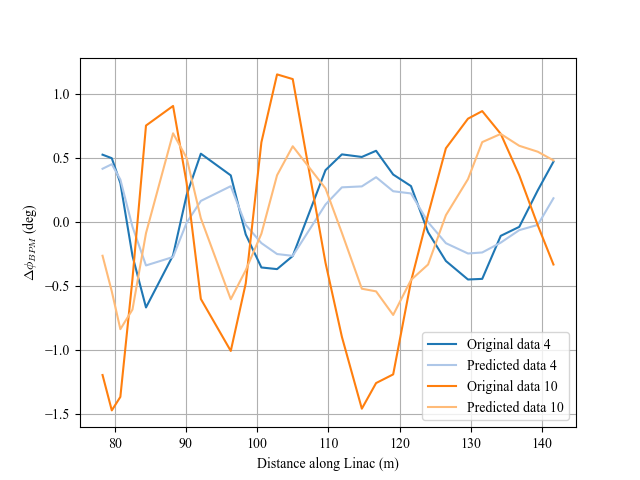

In [34]:
%matplotlib widget
plt.plot(dist_data[6:],osc1[4].mean()[9:], label = 'Original data 4')
plt.plot(dist_data[6:],osc2[4].mean()[9:], label = 'Predicted data 4')
plt.plot(dist_data[6:],osc1[10].mean()[9:], label = 'Original data 10')
plt.plot(dist_data[6:],osc2[10].mean()[9:], label = 'Predicted data 10')
#plt.xticks(rotation=90)
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Distance along Linac (m)')
plt.ylabel('$\Delta \phi_{BPM}$ (deg)')

In [98]:
from scipy.interpolate import griddata

file = './osc_fixRFQ_varyT2T5.csv'
df = pd.read_csv(file,sep=',')

NPX=61
NPY=61

X, Y = np.mgrid[df['L:V5QSET'].min():df['L:V5QSET'].max():NPY*1j,
                df['L:V2QSET'].min():df['L:V2QSET'].max():NPX*1j]
points = (Y.ravel(),X.ravel())
bpms=df.filter(regex="^(?!.*QSET|Unnamed).*").columns

dfnew=pd.DataFrame(zip(Y.ravel(),X.ravel()),columns=["L:V2QSET","L:V5QSET"])
for bpm in bpms:
    dfnew[bpm] = griddata((df['L:V2QSET'],df['L:V5QSET']), df[bpm], points, method='linear')
    
print(dfnew)
#print(df)

      L:V2QSET  L:V5QSET  L:RFQPAH  L:BPM2OF  L:BPM3IF  L:BPM3OF  L:BPM4IF  \
0         -3.0      -2.0       0.0 -6.434326 -6.906128 -5.127563 -5.880737   
1         -2.9      -2.0       0.0 -6.132914 -6.586406 -4.905599 -5.623881   
2         -2.8      -2.0       0.0 -5.831503 -6.266683 -4.683635 -5.367025   
3         -2.7      -2.0       0.0 -5.530091 -5.946961 -4.461670 -5.110169   
4         -2.6      -2.0       0.0 -5.228679 -5.627239 -4.239706 -4.853313   
...        ...       ...       ...       ...       ...       ...       ...   
3716       2.6       2.0       0.0  4.595541  5.211385  3.663737  4.229737   
3717       2.7       2.0       0.0  4.744263  5.365906  3.769226  4.360962   
3718       2.8       2.0       0.0  4.892985  5.520427  3.874715  4.492188   
3719       2.9       2.0       0.0  5.041707  5.674947  3.980204  4.623413   
3720       3.0       2.0       0.0  5.190430  5.829468  4.085693  4.754639   

      L:BPM5IF   L:BPM5OF   L:D02BF  ...   L:D53BF   L:D54BF   

In [107]:
osc3 = [fetch_slice(dfnew,['L:V2QSET','L:V5QSET'],pr[0],[0.058,0.033]) for pr in predicted ]
[print(osc.iloc[:,:3], pr[0]) for (osc,pr) in zip(osc3,predicted)]

      L:V2QSET  L:V5QSET  L:RFQPAH
1849      -1.1       0.0       0.0
1850      -1.0       0.0       0.0 [-1.047 -0.025]
      L:V2QSET  L:V5QSET  L:RFQPAH
1790      -0.9 -0.066667       0.0 [-0.898 -0.068]
      L:V2QSET  L:V5QSET  L:RFQPAH
1671      -0.6      -0.2       0.0 [-0.64  -0.192]
      L:V2QSET  L:V5QSET  L:RFQPAH
1671      -0.6      -0.2       0.0 [-0.564 -0.23 ]
      L:V2QSET  L:V5QSET  L:RFQPAH
1671      -0.6      -0.2       0.0
1672      -0.5      -0.2       0.0 [-0.543 -0.175]
      L:V2QSET  L:V5QSET  L:RFQPAH
1859      -0.1       0.0       0.0 [-0.066  0.02 ]
      L:V2QSET  L:V5QSET  L:RFQPAH
1802       0.3 -0.066667       0.0
1803       0.4 -0.066667       0.0 [ 0.345 -0.043]
      L:V2QSET  L:V5QSET  L:RFQPAH
1682       0.5      -0.2       0.0 [ 0.516 -0.233]
      L:V2QSET  L:V5QSET  L:RFQPAH
1684       0.7      -0.2       0.0 [ 0.686 -0.229]
      L:V2QSET  L:V5QSET  L:RFQPAH
1565       1.0 -0.333333       0.0 [ 0.999 -0.328]
      L:V2QSET  L:V5QSET  L:RFQPAH


[None, None, None, None, None, None, None, None, None, None, None]

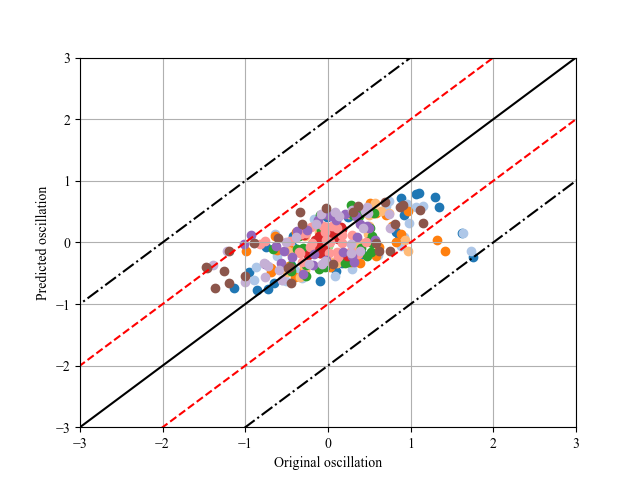

In [108]:
%matplotlib widget
#plt.scatter(osc1[5].iloc[:,3:],osc2[5].iloc[:,3:])
[plt.scatter(o1.mean()[9:],o2.mean()[9:], label='Data %d'%i) for i,(o1,o2) in enumerate(zip(osc1,osc3))]
plt.plot([-11,11],[-11,11],color='k', linestyle = '-')
plt.plot([-11,11],[-9,13],color='k', linestyle = '-.')
plt.plot([-11,11],[-13,9],color='k', linestyle = '-.')
plt.plot([-11,11],[-10,12],color='r', linestyle = '--')
plt.plot([-11,11],[-12,10],color='r', linestyle = '--')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel('Original oscillation')
plt.ylabel('Predicted oscillation')
plt.grid()

Text(0, 0.5, '$\\Delta \\phi_{BPM}$ (deg)')

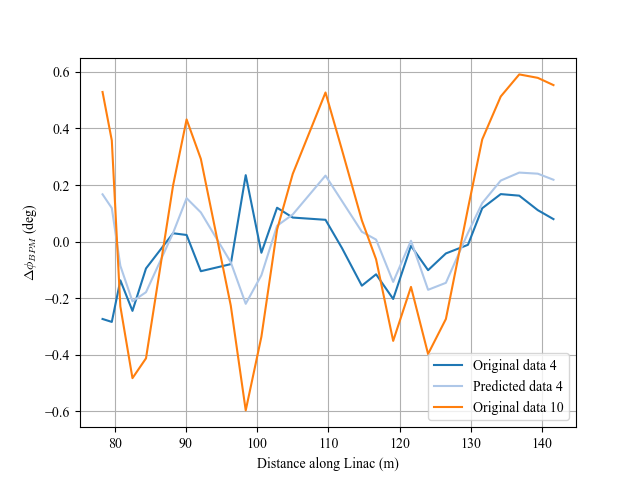

In [111]:
%matplotlib widget
plt.plot(dist_data[6:],osc1[6].mean()[9:], label = 'Original data 4')
plt.plot(dist_data[6:],osc3[6].mean()[9:], label = 'Predicted data 4')
plt.plot(dist_data[6:],osc2[6].mean()[9:], label = 'Original data 10')
#plt.plot(dist_data[6:],osc3[1].mean()[9:], label = 'Predicted data 10')
#plt.xticks(rotation=90)
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Distance along Linac (m)')
plt.ylabel('$\Delta \phi_{BPM}$ (deg)')